In [1]:
pip install mindspore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.0/962.0 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary libraries
import os
import pandas as pd
import cv2
import numpy as np
import mindspore.nn as nn
from mindspore import Model, Tensor, context, load_checkpoint, load_param_into_net
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.dataset import NumpySlicesDataset
from mindspore.dataset.vision import Inter, Resize, Normalize, HWC2CHW
from mindspore.common.initializer import Normal

In [4]:
# Define paths
DATA_PATH = os.path.join("/content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/Training")  # Path to the DATA folder
TEST_PATH = os.path.join("/content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/Testing")  # Path to the TEST folder
LABELS_CSV_PATH = os.path.join("/content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/labelsplant.csv")  # Path to labels.csv

In [5]:
# Load and preprocess the dataset
def load_images_from_folder(folder, target_size=(224, 224)):
    print(f"Loading images from {folder}...")
    images = []
    labels = []
    for class_id in os.listdir(folder):
        class_folder = os.path.join(folder, class_id)
        if not os.path.isdir(class_folder):
            continue
        print(f"Loading images from class {class_id}...")
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to load image {image_path}. Skipping.")
                continue
            image = cv2.resize(image, target_size)
            image = image / 255.0  # Normalize to [0, 1]
            images.append(image)
            labels.append(int(class_id))
    print(f"Loaded {len(images)} images from {folder}.")
    return np.array(images), np.array(labels)

# Load training and test data
print("Loading training data...")
train_images, train_labels = load_images_from_folder(DATA_PATH)
print("Loading test data...")
test_images, test_labels = load_images_from_folder(TEST_PATH)

Loading training data...
Loading images from /content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/Training...
Loading images from class 0...
Loading images from class 1...
Loading images from class 2...
Loaded 3251 images from /content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/Training.
Loading test data...
Loading images from /content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/Testing...
Loaded 0 images from /content/drive/MyDrive/Colab Notebooks/PLD_3_Classes_256/Testing.


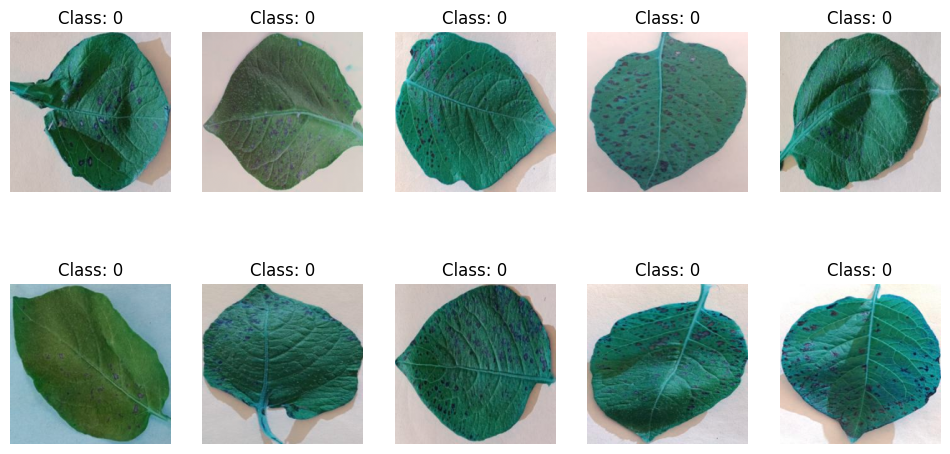

In [6]:
import matplotlib.pyplot as plt

# Function to display sample images
def show_sample_images(images, labels, num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows, 5 columns
        plt.imshow(images[i])  # Display image
        plt.title(f"Class: {labels[i]}")  # Show class label
        plt.axis("off")  # Hide axes
    plt.show()

# Show sample images from training dataset
show_sample_images(train_images, train_labels)


In [7]:
# Split training data into training and validation sets
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")

Training set size: 2600
Validation set size: 651


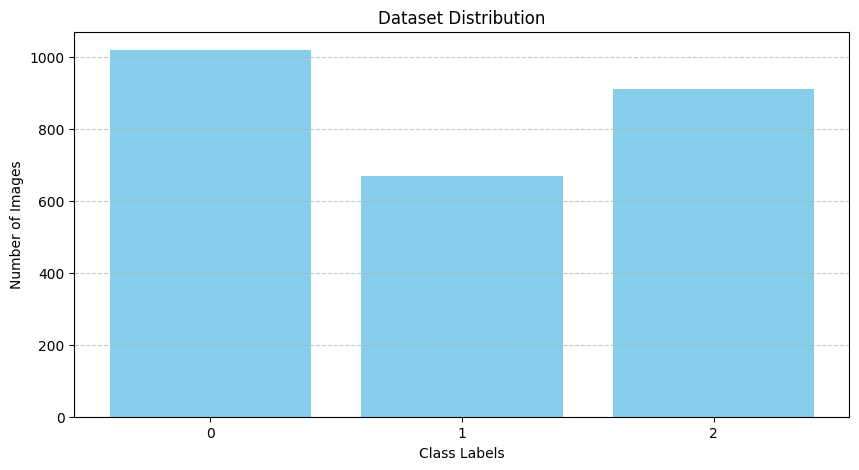

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images per class
class_counts = Counter(train_labels)

# Extract class names and corresponding counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot the dataset distribution
plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color="skyblue")
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.xticks(classes)  # Ensure class labels are properly spaced
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


In [ ]:
# Load labels.csv
print("Loading labels.csv...")
labels_df = pd.read_csv(LABELS_CSV_PATH)
classid_to_name = dict(zip(labels_df["ClassId"], labels_df["Name"]))
print("Labels loaded successfully.")

Loading labels.csv...
Labels loaded successfully.


In [ ]:
# Convert data to MindSpore dataset
def preprocess_dataset(images, labels, is_training=True):
    print("Preprocessing dataset...")
    dataset = NumpySlicesDataset((images, labels), column_names=["image", "label"], shuffle=True)

    # Define transformations
    resize_op = Resize((224, 224), interpolation=Inter.BILINEAR)
    normalize_op = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    hwc2chw_op = HWC2CHW()

    # Apply transformations to the "image" column
    dataset = dataset.map(operations=[resize_op, normalize_op, hwc2chw_op], input_columns="image")
    if is_training:
        dataset = dataset.batch(32, drop_remainder=True)
    else:
        dataset = dataset.batch(32)
    print("Dataset preprocessing complete.")
    return dataset

print("Creating training dataset...")
train_dataset = preprocess_dataset(train_images, train_labels, is_training=True)

print("Creating validation dataset...")
val_dataset = preprocess_dataset(val_images, val_labels, is_training=False)

print("Creating test dataset...")
test_dataset = preprocess_dataset(test_images, test_labels, is_training=False)

Creating training dataset...
Preprocessing dataset...
Dataset preprocessing complete.
Creating validation dataset...
Preprocessing dataset...
Dataset preprocessing complete.
Creating test dataset...
Preprocessing dataset...
Dataset preprocessing complete.


In [ ]:
# Define MobileNetV2 manually
class InvertedResidual(nn.Cell):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, pad_mode='same', has_bias=False)
            )
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6())

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, pad_mode='same', group=hidden_dim, has_bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, pad_mode='same', has_bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.layers = nn.SequentialCell(layers)

    def construct(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        return self.layers(x)

class MobileNetV2(nn.Cell):
    def __init__(self, num_classes=58, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        input_channel = 32
        last_channel = 1280
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, pad_mode='same', has_bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(),
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel

        features.append(
            nn.Conv2d(input_channel, self.last_channel, kernel_size=1, stride=1, pad_mode='same', has_bias=False)
        )
        features.append(nn.BatchNorm2d(self.last_channel))
        features.append(nn.ReLU6())

        self.features = nn.SequentialCell(features)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Dense(self.last_channel, num_classes, weight_init=Normal(0.01))

    def construct(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

print("Defining MobileNetV2...")
net = MobileNetV2(num_classes=58)  # 58 traffic sign classes
print("MobileNetV2 defined successfully.")

Defining MobileNetV2...
MobileNetV2 defined successfully.


In [ ]:
# Define loss function and optimizer
print("Defining loss function and optimizer...")
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizer = nn.Adam(params=net.trainable_params(), learning_rate=0.001)
print("Loss function and optimizer defined.")

Defining loss function and optimizer...
Loss function and optimizer defined.


In [ ]:
# Create the Model object
print("Creating the Model object...")
model = Model(net, loss_fn=loss_fn, optimizer=optimizer, metrics={'accuracy', 'loss'})
print("Model object created successfully.")

Creating the Model object...
Model object created successfully.


In [ ]:
#Load the checkpoint (Add after restart)
checkpoint_path = "/content/drive/MyDrive/CPE178P/DOE/checkpoints_epochs/potato_leaf_model_epochs-1_81.ckpt"
param_dict = load_checkpoint(checkpoint_path)
load_param_into_net(net, param_dict)

([],
 ['global_step',
  'learning_rate',
  'beta1_power',
  'beta2_power',
  'moment1.features.0.weight',
  'moment1.features.1.gamma',
  'moment1.features.1.beta',
  'moment1.features.3.layers.0.weight',
  'moment1.features.3.layers.1.gamma',
  'moment1.features.3.layers.1.beta',
  'moment1.features.3.layers.3.weight',
  'moment1.features.3.layers.4.gamma',
  'moment1.features.3.layers.4.beta',
  'moment1.features.4.layers.0.weight',
  'moment1.features.4.layers.1.gamma',
  'moment1.features.4.layers.1.beta',
  'moment1.features.4.layers.3.weight',
  'moment1.features.4.layers.4.gamma',
  'moment1.features.4.layers.4.beta',
  'moment1.features.4.layers.6.weight',
  'moment1.features.4.layers.7.gamma',
  'moment1.features.4.layers.7.beta',
  'moment1.features.5.layers.0.weight',
  'moment1.features.5.layers.1.gamma',
  'moment1.features.5.layers.1.beta',
  'moment1.features.5.layers.3.weight',
  'moment1.features.5.layers.4.gamma',
  'moment1.features.5.layers.4.beta',
  'moment1.featu

In [ ]:
# Train the model with checkpoint saving
print("Training the model...")

#Load the checkpoint (Add after restart)
checkpoint_path = "/content/drive/MyDrive/CPE178P/DOE/checkpoints_epochs/potato_leaf_model_epochs-1_81.ckpt"
param_dict = load_checkpoint(checkpoint_path)
load_param_into_net(net, param_dict)

# Recreate the training dataset (Remove after recreation)
#print("Recreating training dataset...")
#train_dataset = preprocess_dataset(train_images, train_labels, is_training=True)

# Calculate steps per epoch
steps_per_epoch = len(train_dataset)
print(f"Steps per epoch: {steps_per_epoch}")

# Define checkpoint configuration for saving every 10 steps
config_ck_steps = CheckpointConfig(
    save_checkpoint_steps=10,  # Save checkpoint every 10 steps
    keep_checkpoint_max=10,    # Keep only the latest 10 checkpoints
)

# Define checkpoint callback for saving every 10 steps
ckpt_callback_steps = ModelCheckpoint(
    prefix="potato_leaf_model_steps",  # Prefix for checkpoint filenames
    directory="/content/drive/MyDrive/CPE178P/DOE/checkpoints_steps",    # Directory to save checkpoints
    config=config_ck_steps,
)

# Define checkpoint configuration for saving every epoch
config_ck_epochs = CheckpointConfig(
    save_checkpoint_steps=steps_per_epoch,  # Save checkpoint every epoch
    keep_checkpoint_max=10,                # Keep only the latest 10 checkpoints
)

# Define checkpoint callback for saving every epoch
ckpt_callback_epochs = ModelCheckpoint(
    prefix="potato_leaf_model_epochs",  # Prefix for checkpoint filenames
    directory="/content/drive/MyDrive/CPE178P/DOE/checkpoints_epochs",    # Directory to save checkpoints
    config=config_ck_epochs,
)

# Custom callback to print epoch, step, training loss, and validation loss
class EpochStepLossMonitor(LossMonitor):
    def __init__(self, val_dataset):
        super(EpochStepLossMonitor, self).__init__()
        self.val_dataset = val_dataset

    def on_train_step_end(self, run_context):
        cb_params = run_context.original_args()
        epoch = cb_params.cur_epoch_num
        step = cb_params.cur_step_num
        train_loss = cb_params.net_outputs

        # Calculate validation loss
        val_loss = model.eval(self.val_dataset, dataset_sink_mode=False)['loss']
        print(f"Epoch: [{epoch}], Step: [{step}], Training Loss: [{train_loss}], Validation Loss: [{val_loss}]")

# Train the model with checkpoint callbacks
model.train(epoch=10, train_dataset=train_dataset, callbacks=[EpochStepLossMonitor(val_dataset), ckpt_callback_steps, ckpt_callback_epochs])
print("Training complete.")

# Custom callback to print epoch, step, and loss
class EpochStepLossMonitor(LossMonitor):
    def on_train_step_end(self, run_context):
        cb_params = run_context.original_args()
        epoch = cb_params.cur_epoch_num
        step = cb_params.cur_step_num
        loss = cb_params.net_outputs
        print(f"Epoch: {epoch}, Step: {step}, Loss is {loss}")

Training the model...
Steps per epoch: 81
Epoch: [1], Step: [1], Training Loss: [0.5596044], Validation Loss: [1.992031528836205]
Epoch: [1], Step: [2], Training Loss: [0.6279612], Validation Loss: [2.051711136386508]
Epoch: [1], Step: [3], Training Loss: [0.72720784], Validation Loss: [2.005823186465672]
Epoch: [1], Step: [4], Training Loss: [0.9794765], Validation Loss: [1.1120937353088742]
Epoch: [1], Step: [5], Training Loss: [0.7658592], Validation Loss: [1.035282430194673]
Epoch: [1], Step: [6], Training Loss: [0.4810365], Validation Loss: [0.9232228866645268]
Epoch: [1], Step: [7], Training Loss: [0.82970834], Validation Loss: [0.9695901558512733]
Epoch: [1], Step: [8], Training Loss: [1.0551846], Validation Loss: [1.2072235260690962]
Epoch: [1], Step: [9], Training Loss: [0.8077012], Validation Loss: [1.4995861394064767]
Epoch: [1], Step: [10], Training Loss: [0.4409173], Validation Loss: [1.6387948365438552]
Epoch: [1], Step: [11], Training Loss: [0.62764114], Validation Loss:

In [ ]:
print(f"Dataset Type: {type(test_dataset)}")


Dataset Type: <class 'mindspore.dataset.engine.datasets.BatchDataset'>


In [ ]:
import os

data_path = "your_dataset_path_here"  # Update with actual dataset path
print(f"Dataset exists: {os.path.exists(data_path)}")


Dataset exists: False


In [ ]:
# Evaluate the model
print("Evaluating the model...")
result = model.eval(test_dataset)
print(f"Test Accuracy: {result['accuracy']}")

Evaluating the model...


RuntimeError: Syntax error. 

------------------------------------------------------------------
- Dataset Pipeline Error Message: 
------------------------------------------------------------------
[ERROR] GeneratorNode: data row of input source must not be 0, got: 0.

------------------------------------------------------------------
- C++ Call Stack: (For framework developers) 
------------------------------------------------------------------
mindspore/ccsrc/minddata/dataset/engine/ir/datasetops/source/generator_node.cc(135).




In [ ]:
# Save the final model
print("Saving the final model...")
from mindspore import save_checkpoint
save_checkpoint(net, "potato_leaf_model_final.ckpt")
print("Final model saved as potatoc_leaf_model_final.ckpt.")

In [ ]:
# Inference
def predict(image_path, model):
    print(f"Predicting image {image_path}...")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image {image_path}.")
        return None
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize
    image = Tensor(image, mstype.float32)
    output = model.predict(image)
    predicted_class = np.argmax(output.asnumpy(), axis=1)
    predicted_class_id = predicted_class[0]
    predicted_class_name = classid_to_name.get(predicted_class_id, "Unknown")
    print(f"Predicted class ID: {predicted_class_id}, Name: {predicted_class_name}")
    return predicted_class_id, predicted_class_name

In [ ]:
# Example usage
print("Running inference on a test image...")
test_image_path = os.path.join(TEST_PATH, "test_image.jpg")
predicted_class_id, predicted_class_name = predict(test_image_path, model)
print(f"Predicted Class ID: {predicted_class_id}, Name: {predicted_class_name}")

Running inference on a test image...


NameError: name 'os' is not defined